In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
from transformers import GPTNeoXForCausalLM, AutoTokenizer

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import numpy as np

# Process Duplicates

In [2]:
cluster = SLURMCluster(cores=8,
                    processes=4,
                    memory="32GB",
                    walltime="12:00:00",
                    # project="fiete",
                    queue="normal",
                    job_extra_directives=["--output=../logs/%j.out", "--error=../logs/%j.out"]
                    )
cluster.scale(jobs=32)
print("Dashboard: ", cluster.dashboard_link)

client = Client(cluster)
client

/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36189 instead
  warnings.warn(


Dashboard:  http://172.16.20.123:36189/status


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.16.20.123:36189/status,
Dashboard: http://172.16.20.123:36189/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.20.123:35677,Workers: 0
Dashboard: http://172.16.20.123:36189/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
matches = []
lengths = []
for j in range(100, 110):
    cur_len = 0
    for i in range(11):
        x = da.from_npy_stack(f'/om/tmp/memorization/matches-count-a2a-opt-amber/{j}-{i}/')
        matches.append(x)
        cur_len += x.shape[1]
    lengths.append(cur_len)
m = da.concatenate(matches, axis=1)


(array([[1.38089e+05, 3.02730e+04, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 1.00000e+00],
        [1.66650e+05, 4.04800e+03, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [1.55385e+05, 1.53080e+04, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        ...,
        [1.06383e+05, 6.42310e+04, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [8.52830e+04, 8.53170e+04, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [9.91070e+04, 7.14860e+04, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]),
 array([       0.  ,   170697.59,   341395.18,   512092.77,   682790.36,
          853487.95,  1024185.54,  1194883.13,  1365580.72,  1536278.31,
         1706975.9 ,  1877673.49,  2048371.08,  2219068.67,  2389766.26,
         2560463.85,  2731161.44,  2901859.03,  3072556.62,  3243254.21,
         3413951.8 ,  3584649.39,  3755346.98,  3926044.57,  4096742.16,
        

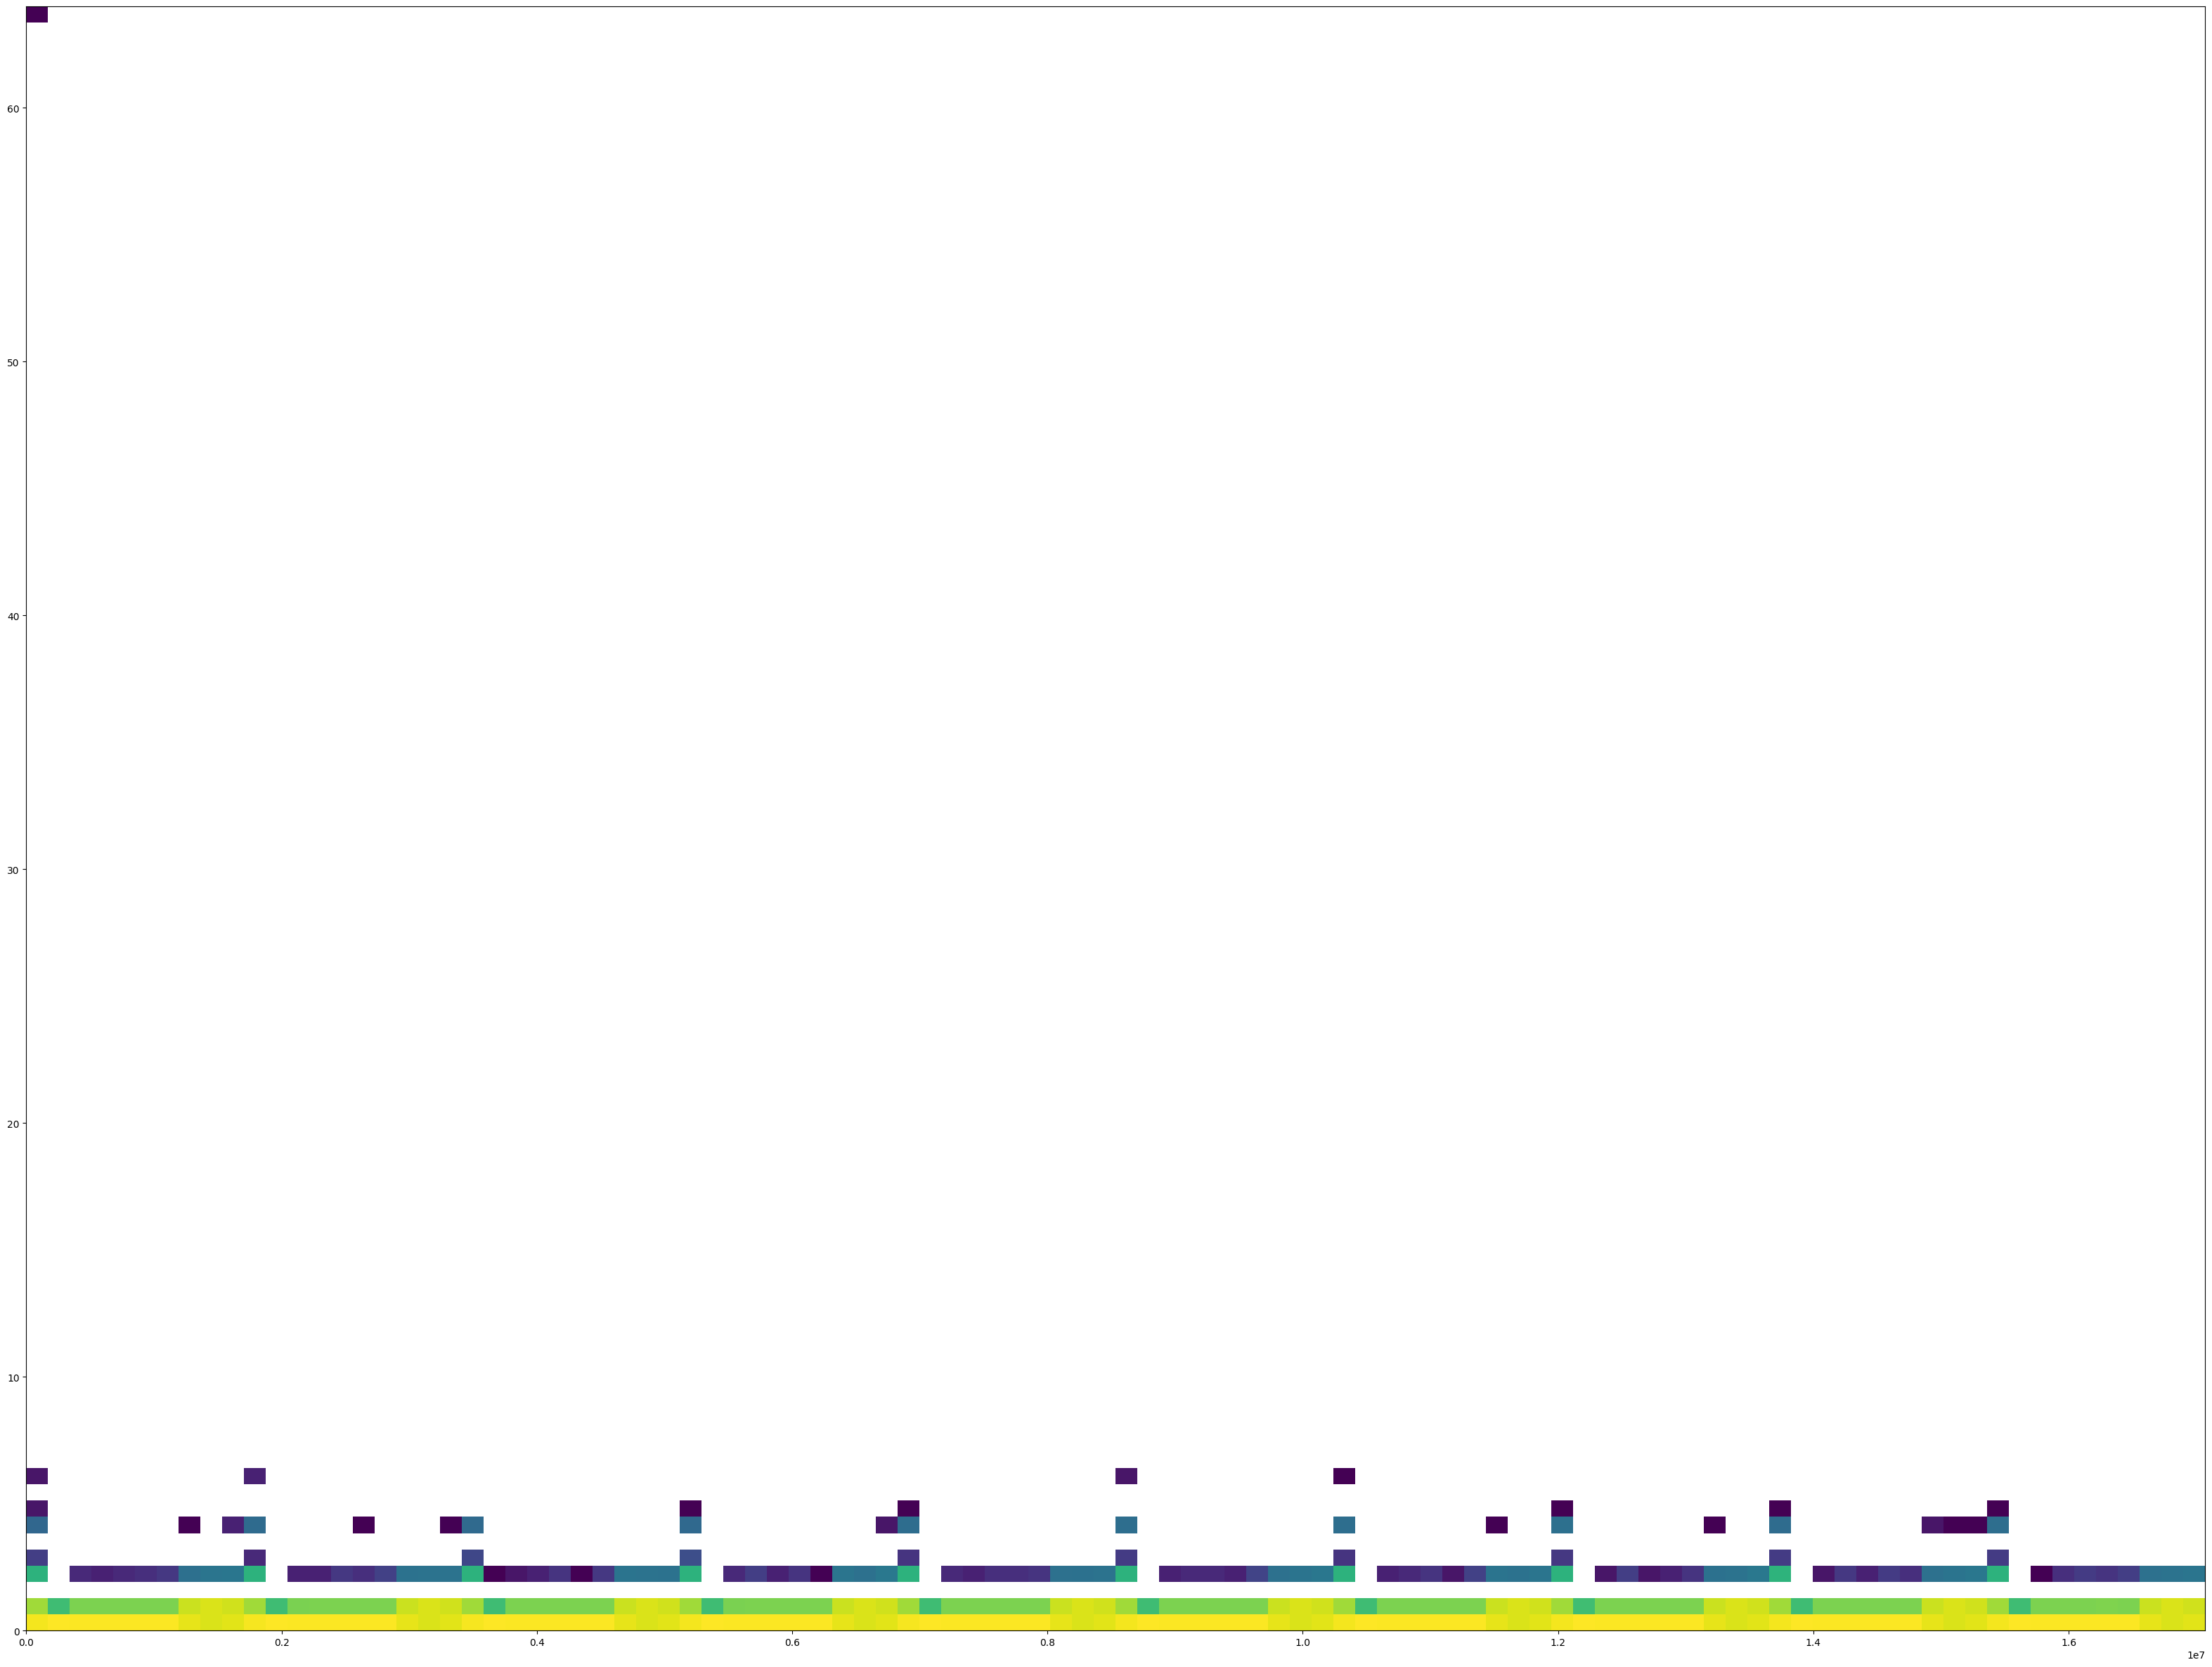

In [4]:
match_0 = m[100, :].compute()
f, ax = plt.subplots(figsize=(40, 30))
ax.hist2d(np.arange(len(match_0)), match_0.T, norm='log', bins=100)


In [5]:
counts = []
bsize = lengths[0]
for k in range(0, 10):
    counts.append(da.topk(m[:, k*bsize:(k+1)*bsize], 10, axis=1))
m_topk = da.stack(counts).compute()
np.save("../results/topk-01-amber.npy", m_topk)

In [5]:
bsize = lengths[0]
for k in range(10):
    counts = []
    for i in [30]:
        counts.append(da.sum(m[:, k*bsize:(k+1)*bsize] >= i, axis=1))
    np.save(f"../results/repeat_count-amber-{k}.npy", da.stack(counts, axis=1).compute())
# repeat_count = da.stack(ocounts).compute()
